## Import datasets

In [1]:
import torch
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from model_v3 import *
from utils import *

## Data transformation

In [4]:
class CIFAR10_ds(datasets.CIFAR10):
    def __init__(self, root=".", train=True, download=True, transform= None):
        super().__init__(root=root, train=train, download=download, transform=transform)
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
 

In [5]:
train_transforms = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, 
                         min_width=16, fill_value=(0.4914, 0.4822 ,0.4465), mask_fill_value = None),
        A.HorizontalFlip(p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)

In [6]:
test_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
    ToTensorV2()
])

In [7]:
train_data = CIFAR10_ds(root=".", train=True, download=True, transform=train_transforms)
test_data = CIFAR10_ds(root=".", train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_data

Dataset CIFAR10_ds
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose([
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
             HorizontalFlip(always_apply=False, p=0.5),
             RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit=(-15, 15), b_shift_limit=(-15, 15)),
             RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
             Normalize(always_apply=False, p=1.0, me

In [9]:
batch_size = 128

kwargs = dict(shuffle=True, batch_size=batch_size) 

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

In [10]:
classes = train_data.classes

class_count = {}
for _, index in train_data:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)

{'frog': 5000, 'truck': 5000, 'deer': 5000, 'automobile': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'airplane': 5000}


## Sample image with augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 32, 32])


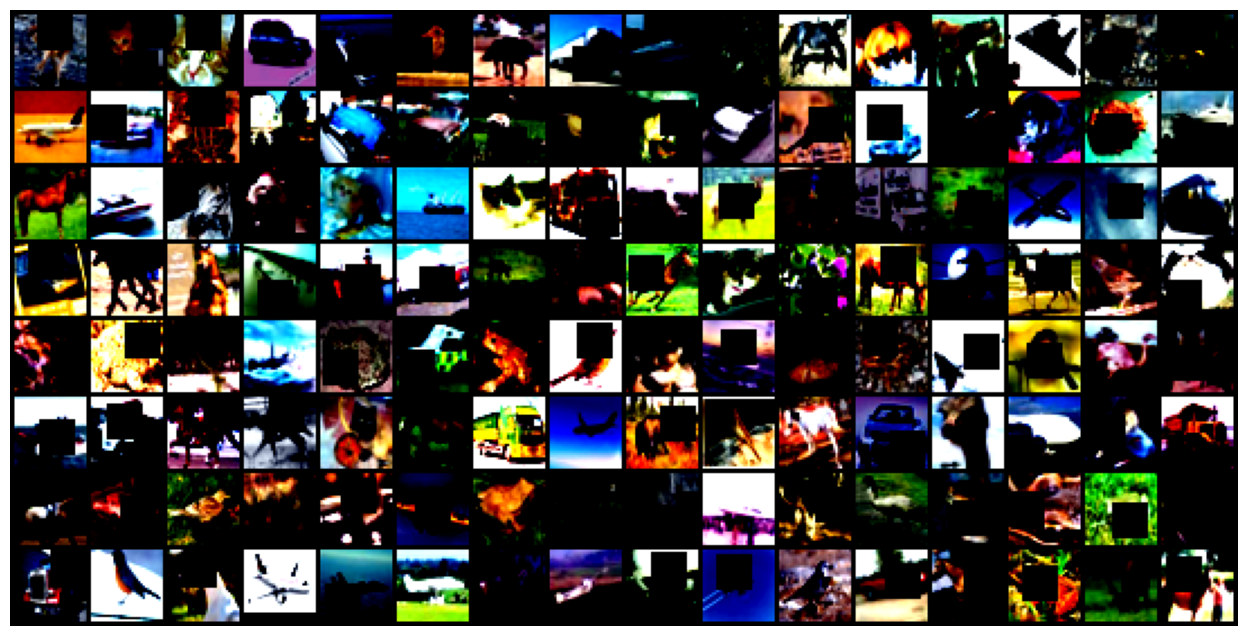

In [11]:
for images, label in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Neural net summary

In [12]:
get_summary(Net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 26, 26]           7,104
       BatchNorm2d-2           [-1, 48, 26, 26]              96
              ReLU-3           [-1, 48, 26, 26]               0
           Dropout-4           [-1, 48, 26, 26]               0
            Conv2d-5           [-1, 48, 24, 24]             480
       BatchNorm2d-6           [-1, 48, 24, 24]              96
              ReLU-7           [-1, 48, 24, 24]               0
           Dropout-8           [-1, 48, 24, 24]               0
            Conv2d-9           [-1, 64, 20, 20]          27,712
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
          Dropout-12           [-1, 64, 20, 20]               0
    ResidualBlock-13           [-1, 64, 20, 20]               0
           Conv2d-14          [-1, 128,

<function torchsummary.torchsummary.summary(model, input_size, batch_size=-1, device='cuda')>

## Training the data and calculating validation results

In [13]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# New Line
train_criterion = nn.CrossEntropyLoss() #Loss function
test_criterion = nn.CrossEntropyLoss() #Loss function
num_epochs = 50

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, train_criterion)
    print(train_acc_val)
    test_acc_val, test_loss = test(model, device, test_loader, test_criterion)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))

Epoch 1


Train: Loss=1.6555 Batch_id=390 Accuracy=31.63: 100%|█| 391/391 [05:33<00:00,  1


31.628
Test set: Average loss: 1.5282, Accuracy: 4229/10000 (42.29%)

Epoch 1: SGD lr 0.0500 -> 0.0400
Epoch 2


Train: Loss=1.4454 Batch_id=390 Accuracy=44.01: 100%|█| 391/391 [08:05<00:00,  1


44.01
Test set: Average loss: 1.2452, Accuracy: 5641/10000 (56.41%)

Epoch 2: SGD lr 0.0400 -> 0.0320
Epoch 3


Train: Loss=1.3467 Batch_id=390 Accuracy=49.94: 100%|█| 391/391 [12:25<00:00,  1


49.94
Test set: Average loss: 1.1801, Accuracy: 5727/10000 (57.27%)

Epoch 3: SGD lr 0.0320 -> 0.0256
Epoch 4


Train: Loss=1.2823 Batch_id=186 Accuracy=52.80:  48%|▍| 187/391 [07:53<07:53,  2

## Plots

In [ ]:
plot_loss(train_losses, train_acc, test_losses, test_acc)

## Misclassified dataset

In [ ]:
model.eval()

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []

for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True) 
    idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
    if idxs_mask.numel(): 
        incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
        incorrect_labels.append(target[idxs_mask].cpu().numpy())
        incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy())

In [ ]:
print(incorrect_labels[0])
print(incorrect_pred[0])

In [ ]:
print(incorrect_examples[0][0])

## Sample Misclassified Images

In [ ]:
import numpy as np
fig = plt.figure(figsize=(20, 8))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = incorrect_examples[0][idx]
    img = img/2 + 0.5
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(incorrect_examples[0][idx], (1, 2, 0)))
    ax.set_title(f"Predicted label: {classes[incorrect_pred[0][idx]]}\n Actual label: {classes[incorrect_labels[0][idx]]}")
    